In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re

# Preprocessing

In [2]:
file_path = 'D:\Data'
train_path = os.path.join(file_path, 'preprocess_data.csv')
test_path = os.path.join(file_path, 'preprocess_test.csv')
sam_sub = os.path.join(file_path, 'sample_submission.csv')

In [3]:
df_sample = pd.read_csv(sam_sub)
df_test = pd.read_csv(test_path)
df = pd.read_csv(train_path)

In [4]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r"(http|https)://[a-zA-Z0-9\.\%\$\!\?\&\=-]+(/[a-zA-Z0-9\.\%\$\!\?\&\=-]+)*", "",text)
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = ' '.join(text.split())
    return text

In [4]:
df_copy = df.copy()
#df_copy['text'] = df['text'].apply(preprocess)

In [10]:
#df_test['text'] = df['text'].apply(preprocess)

In [5]:
from collections import Counter
vocabulary = Counter()
for i in range(len(df_copy)):
    vocabulary.update(df_copy.loc[i, 'text'].split())
for i in range(len(df_test)):
    vocabulary.update(df_test.loc[i, 'text'].split())
vocabulary_size = 1500
vocabulary_truncate = [word for word, count in vocabulary.most_common()[:vocabulary_size]]

In [6]:
words = tf.constant(vocabulary_truncate)
words_id = tf.range(len(vocabulary_truncate), dtype = tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, words_id)
num_oov_buckets = 100
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [129]:
table.lookup(tf.constant(["barbados bridgetown jamaica two cars set ablaze santa cruz head of the st elizabeth police superintende".split()])) + 1

<tf.Tensor: shape=(1, 16), dtype=int64, numpy=
array([[1541, 1573, 1520,  119, 1550,  244,  598, 1553, 1567,  278,    7,
           1,  481, 1555,   87, 1548]], dtype=int64)>

In [7]:
list_input = []
list_output = []
for i  in range(len(df_copy)):
    list_input.append(table.lookup(tf.constant(df_copy.loc[i, 'text'].split())) + 1)
    list_output.append([df_copy.loc[i, 'target']])

In [8]:
test_list_input = []
for i  in range(len(df_test)):
    test_list_input.append(table.lookup(tf.constant(df_test.loc[i, 'text'].split())) + 1)

In [9]:
def tensor_to_Dense(tensors):
    values = tf.concat(tensors, axis=0)
    lens = tf.stack([tf.shape(t, out_type=tf.int64)[0] for t in tensors])
    dataset = tf.RaggedTensor.from_row_lengths(values, lens)
    dataset = dataset.to_tensor()
    return dataset

In [10]:
input_data = tensor_to_Dense(list_input)
output_data = tensor_to_Dense(list_output)
test_input = tensor_to_Dense(test_list_input)

In [11]:
train_size = int(len(df) * 0.9)
train_input = input_data[:train_size]
val_input = input_data[train_size:]
train_output = output_data[:train_size]
val_output = output_data[train_size:]

In [12]:
train_output = tf.cast(train_output, tf.int64)
val_output = tf.cast(val_output, tf.int64)

In [13]:
train = tf.concat([train_input, train_output], axis = 1)
train = tf.data.Dataset.from_tensor_slices(train).shuffle(1000).batch(32)
train = train.map(lambda data : (data[:, :-1], data[:, -1:]))
train.prefetch(tf.data.AUTOTUNE)

val = tf.concat([val_input, val_output], axis = 1)
val = tf.data.Dataset.from_tensor_slices(val).shuffle(1000).batch(32)
val = val.map(lambda data : (data[:, :-1], data[:, -1:]))
val.prefetch(tf.data.AUTOTUNE)

<PrefetchDataset shapes: ((None, 34), (None, 1)), types: (tf.int64, tf.int64)>

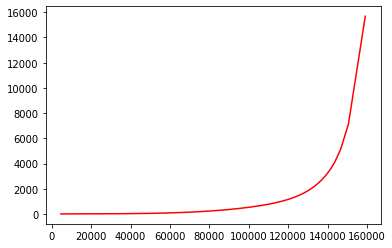

In [63]:
list_freq = [time for word, time in vocabulary.most_common()]
np_list_freq = np.cumsum(list_freq)
bins = [0,1000,2000,3000,4000,5000]
plt.plot(np_list_freq, np.linspace(1, len(list_freq), len(list_freq)), 'r-')
plt.show()

In [71]:
for i in range(len(list_freq)):
    if np_list_freq[i] >= np_list_freq[-1]*90/100:
        index = i + 1
        print(index)
        break

3990


In [65]:
list_freq[-1]

1

In [97]:
list_freq[1800]

11

# Model LSTM

In [14]:
class round_accuracy(keras.metrics.Metric):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.accuracy = tf.keras.metrics.Accuracy(name="accuracy", dtype=None)
    self.total = self.add_weight('total', initializer = 'zeros')
    self.count = self.add_weight('count', initializer = 'zeros')
  def update_state(self, y_true, y_pred, sample_weight = None):
    y_pred = tf.math.round(y_pred)
    metric = self.accuracy(y_true, y_pred)
    self.total.assign_add(metric)
    self.count.assign_add(tf.cast(1, tf.float32))
  def result(self):
    return self.total/self.count

In [15]:
custom_metric = round_accuracy()

In [16]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=3e-5,
)

In [25]:
model = keras.Sequential([
    keras.layers.Embedding(vocabulary_size + num_oov_buckets, 128, mask_zero = True,
                          input_shape = [None]),
    keras.layers.LSTM(8, return_sequences = True,
                     recurrent_regularizer = tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
                     #activation = 'relu', kernel_initializer = 'he_normal'
                     ),
    keras.layers.Dropout(0.2),
    #keras.layers.LSTM(32, return_sequences = True,
    #                  recurrent_regularizer = tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3)
    #                 ),
    #keras.layers.Dropout(0.2),
    keras.layers.LSTM(8, recurrent_regularizer = tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
                     #activation = 'relu', kernel_initializer = 'he_normal'
                     ),
    keras.layers.Dense(1, activation = "sigmoid")
])

In [26]:
model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = [custom_metric])

In [27]:
early_stoppping = keras.callbacks.EarlyStopping(patience = 5,
                                               restore_best_weights = True)

In [28]:
history = model.fit(train, validation_data = val, epochs = 500, callbacks = [early_stoppping])

Epoch 1/500
215/215 [==============================] - 10s 26ms/step - loss: 0.7668 - round_accuracy: 0.6437 - val_loss: 0.7569 - val_round_accuracy: 0.5761
Epoch 2/500
215/215 [==============================] - 4s 19ms/step - loss: 0.7393 - round_accuracy: 0.6118 - val_loss: 0.7310 - val_round_accuracy: 0.5784
Epoch 3/500
215/215 [==============================] - 4s 19ms/step - loss: 0.7057 - round_accuracy: 0.6729 - val_loss: 0.6979 - val_round_accuracy: 0.6815
Epoch 4/500
215/215 [==============================] - 4s 19ms/step - loss: 0.6686 - round_accuracy: 0.7372 - val_loss: 0.6630 - val_round_accuracy: 0.7632
Epoch 5/500
215/215 [==============================] - 4s 20ms/step - loss: 0.6351 - round_accuracy: 0.7788 - val_loss: 0.6333 - val_round_accuracy: 0.7541
Epoch 6/500
215/215 [==============================] - 4s 20ms/step - loss: 0.6061 - round_accuracy: 0.8023 - val_loss: 0.6104 - val_round_accuracy: 0.7872
Epoch 7/500
215/215 [==============================] - 4s 20ms/

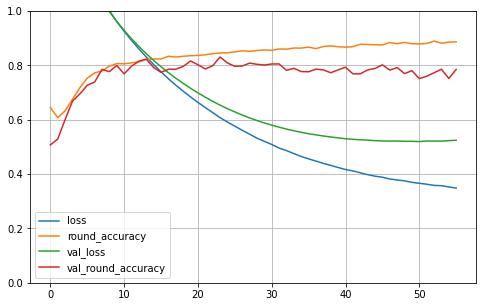

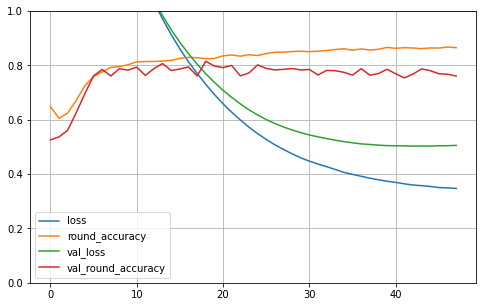

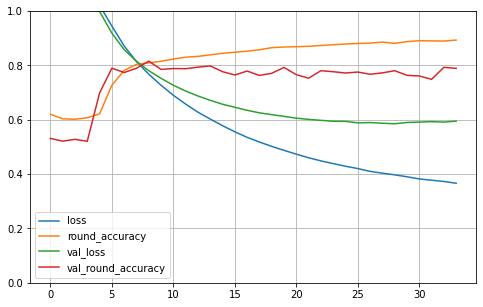

In [153]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Machanist attention

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

# Prediction

In [28]:
#pd.DataFrame(history.history).plot(figsize = (16,10))
#plt.grid(True)
#plt.gca().set_ylim(0,1)
#plt.show()

In [105]:
prediction = model.predict(val)

In [100]:
prediction.shape

(762, 1)

In [106]:
round_prediction = np.round(prediction)
round_prediction = round_prediction.astype(np.int32)

In [93]:
filters = (val_output.numpy() == df_copy.loc[train_size:, 'target'].to_numpy().reshape(-1,1))

In [107]:
df_output = df_copy.loc[train_size: ,'text']
df_output = df_output.to_frame()
df_output['target'] = val_output.numpy()#df_copy.loc[train_size:, 'target']
df_output['predict'] = round_prediction

In [108]:
filters = (val_output.numpy() != round_prediction)
df_output = df_output.loc[filters]

In [69]:
df_output.to_csv(r'D:\Data\val_result.csv', index=False)

In [109]:
df_output

,text,target,predict
6852,pt chat yes I feel the root of that be shame w...,1,0
6854,photo lavenderpoetrycafe the forget history of...,1,0
6855,trauma injury involve kid and sport usually cy...,1,0
6861,why marijuana be critical for research in trea...,0,1
6863,both kid got haircut w minimal trauma clearly ...,0,1
...,...,...,...
7603,official say a quarantine be in place at an al...,1,0
7606,suicide bomber kill 15 in saudi security site ...,1,0
7608,two giant crane hold a bridge collapse into ne...,1,0
7609,aria array thetawniest the out of control wild...,1,0
